Author: Giulio Cesare Mastrocinque Santo

TL; DR
---
The objective of this notebook is to exemplify how to use a Recurrent Neural
Network (RNN) with Pytorch.

In [ ]:
from typing import Tuple, Dict

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

### Load Data

The data adopted in this notebook is the [Room Occupancy Estimation Data Set](https://archive.ics.uci.edu/ml/datasets/Room+Occupancy+Estimation) extracted from UCI Machine Learning Repository, which belongs to the following paper:



> Adarsh Pal Singh, Vivek Jain, Sachin Chaudhari, Frank Alexander Kraemer, Stefan Werner and Vishal Garg, â€œMachine Learning-Based Occupancy Estimation Using Multivariate Sensor Nodes,â€ in 2018 IEEE Globecom Workshops (GC Wkshps), 2018.

Quoting from UCI website:

> The data was collected for a period of 4 days in a controlled manner with the occupancy in the room varying between 0 and 3 people. The ground truth of the occupancy count in the room was noted manually.







In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00640/Occupancy_Estimation.csv -P sample_data/data/occupancy_estimation/

--2022-10-08 22:14:30--  https://archive.ics.uci.edu/ml/machine-learning-databases/00640/Occupancy_Estimation.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 931630 (910K) [application/x-httpd-php]
Saving to: ‘sample_data/data/occupancy_estimation/Occupancy_Estimation.csv.1’

Occupancy_Estimatio 100%[===================>] 909.79K  3.03MB/s    in 0.3s    

2022-10-08 22:14:30 (3.03 MB/s) - ‘sample_data/data/occupancy_estimation/Occupancy_Estimation.csv.1’ saved [931630/931630]



### Data Overview

In [ ]:
df = pd.read_csv('sample_data/data/occupancy_estimation/Occupancy_Estimation.csv')

In [ ]:
df.head()

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1


### Statiscal Variables

In [ ]:
FEATURES = [
    'S1_Temp', 
    'S2_Temp', 
    'S3_Temp', 
    'S4_Temp', 
    'S1_Light',
    'S2_Light', 
    'S3_Light', 
    'S4_Light', 
    'S1_Sound', 
    'S2_Sound', 
    'S3_Sound',
    'S4_Sound'
]

TARGET = "Room_Occupancy_Count"

### **Create Data Reader**

In [ ]:
class OccupancyDataset(Dataset):

  def __init__(
      self, 
      data_path: str, 
      features: list, 
      target: str,
      lag_size: int = 5
  ):
    super(OccupancyDataset, self).__init__()

    self.data = pd.read_csv(data_path) \
        .sort_values(by="Time", ascending=True) \
        .reset_index(drop=True)
    self.features = features
    self.target = target
    self.lag_size = lag_size


  def __len__(self) -> int:

      return self.data.shape[0]

  def __getitem__(self, idx: int) -> Tuple[np.ndarray, np.ndarray]:

      if idx >= self.lag_size:
          X = self.data.loc[
              idx-self.lag_size+1:idx, 
              self.features
          ].values
      else:
          X = pd.concat(
              [pd.DataFrame(self.data.loc[0,self.features]).T]*self.lag_size, 
              axis=0
          ).values
          
      y = self.data.loc[idx, self.target]

      X = X.astype(float)
      y = np.array([y]).astype(float)

      return torch.from_numpy(X), torch.from_numpy(y)

In [ ]:
class CreateLoaders:

    def __init__(
      self,
      dataset: Dataset, 
      train_size: float,
      valid_size: float,
      batch_size: int = None,
      random_state: int = 42
    ):

      self.dataset = dataset
      self.batch_size = batch_size
      self.train_size = train_size
      self.valid_size = valid_size
      self.random_state = random_state

    @staticmethod
    def _create_subsets(
        dataset: Dataset, 
        train_idxs: list, 
        validation_idxs: list, 
        testing_idxs: list
    ) -> Tuple[Subset, Subset, Subset]:

      training_subset = torch.utils.data.Subset(dataset, train_idxs)
      validation_subset = torch.utils.data.Subset(dataset, validation_idxs)
      testing_subset = torch.utils.data.Subset(dataset, testing_idxs)

      return training_subset, validation_subset, testing_subset

    @staticmethod
    def _train_test_valid_split(
        data_length: Dataset,
        train_size: float,
        valid_size: float,
        random_state: int
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:

      train_idxs, remaining_idxs = train_test_split(
          range(data_length),
          train_size=train_size,
          random_state=random_state
      )

      validation_idxs, testing_idxs = train_test_split(
          remaining_idxs,
          train_size=valid_size,
          random_state=random_state,
      )     

      return train_idxs, validation_idxs, testing_idxs        

    def build(self) -> Dict[str, DataLoader]:

        train_idxs, validation_idxs, testing_idxs = self._train_test_valid_split(
            data_length = len(self.dataset),
            train_size = self.train_size,
            valid_size = self.valid_size,
            random_state = self.random_state
        )

        training_subset, validation_subset, testing_subset = self._create_subsets(
            dataset = self.dataset,
            train_idxs = train_idxs,
            validation_idxs = validation_idxs,
            testing_idxs = testing_idxs
        )

        loaders = {
            "train": DataLoader(training_subset, batch_size=self.batch_size, drop_last=True),
            "valid": DataLoader(validation_subset, batch_size=self.batch_size, drop_last=True),
            "test": DataLoader(testing_subset, batch_size=self.batch_size, drop_last=True)
        }

        return loaders, testing_subset

In [ ]:
occupancy_torch_dataset = OccupancyDataset(
    data_path = "sample_data/data/occupancy_estimation/Occupancy_Estimation.csv",
    features = FEATURES,
    target = TARGET,
    lag_size = 7
)

In [ ]:
loader_builder = CreateLoaders(
    dataset = occupancy_torch_dataset,
    train_size = 0.7,
    valid_size = 0.1,
    batch_size = 50,
    random_state = 42
)

In [ ]:
loaders, testing_subset = loader_builder.build()

In [ ]:
next(iter(loaders["train"]))[0].shape

torch.Size([50, 7, 12])

### **Build Network**

#### Deep Recurrent Networks

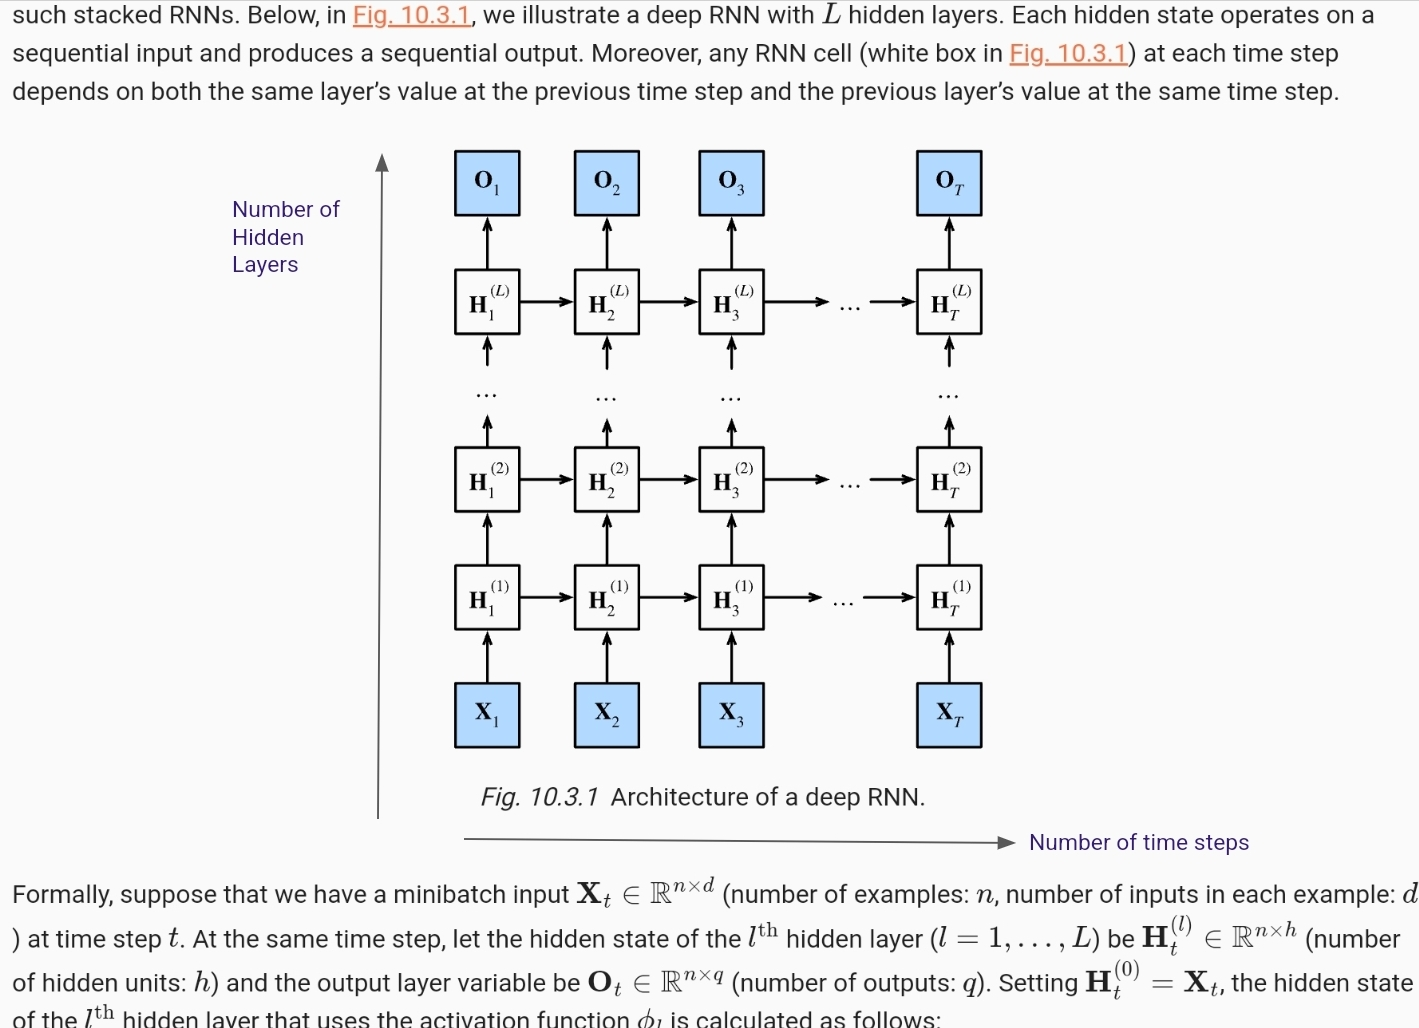

Edited from the following source: [Dive Into Deep Learning](https://d2l.ai/chapter_recurrent-modern/deep-rnn.html)

In [ ]:
class RNN(nn.Module):
  def __init__(self, input_size, output_size, hidden_dim, n_layers):
    super(RNN, self).__init__()
    self.hidden_dim = hidden_dim
    self.output_size = output_size
    self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
    self.linear = nn.Linear(hidden_dim, output_size)

  def forward(self, x, hidden):
    batch_size = x.size(0)

    #r_out: (batch_size, seq_length (T), hidden_dim (h))
    #hidden: (batch_size, hidden_dim) -> This is the state vector! 
    #To understando the difference between r_out and hidden:
    #https://stackoverflow.com/a/48305882
    r_out, hidden = self.rnn(x, hidden)

    #Apply Linear Layer to the last time step
    #(batch_size, hidden_dim)
    output = self.linear(r_out[:, -1])

    return output, hidden

In the case of an Elman network, the input and the state of the previous time step are just concatenated:

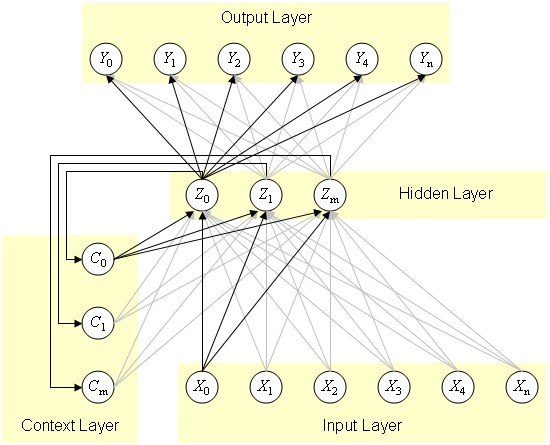

Source: https://qr.ae/pvZqk4

Notice that C0, C1, ..., Cm are the states from the previous time step. We have a value of the state for each sample. The pytorch hidden vector is exactly the value of these state, which is why it have dimension (batch_size, hidden_dim), being hidden_dim the dimension of the hidden layer. The state is nothing more than a delayed version of the output of the hidden layer.


In [ ]:
input_size = 12
output_size = 1
hidden_dim = 32
n_layers = 1

In [ ]:
rnn_learner = RNN(input_size, output_size, hidden_dim, n_layers).double()

In [ ]:
rnn_learner

RNN(
  (rnn): RNN(12, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn_learner.parameters(), lr=0.001)

### **Train Network**

In [ ]:
def train(
    learner,
    loaders, 
    n_epochs, 
    print_every
  ):

  # Initialize the hidden state
  hidden = None

  # Perform Training
  epoch_train_loss = []
  epoch_valid_loss = []
  for epoch in range(n_epochs):

      train_losses = []
      valid_losses = []
      for X, y in loaders["train"]:
          prediction, hidden = learner(X, hidden)
          hidden = hidden.data
          loss = criterion(prediction, y)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          train_losses.append(loss.detach().numpy())

      with torch.no_grad():
          for X, y in loaders["valid"]:
              prediction, _ = learner(X, hidden)
              loss = criterion(prediction, y)
              valid_losses.append(loss.detach().numpy())

      mean_train_loss = np.around(np.mean(train_losses),4)
      mean_test_loss = np.around(np.mean(valid_losses), 4)

      print(
          f"EPOCH {epoch+1}/{n_epochs}: " +
          f"Training Loss: {mean_train_loss}, " + 
          f"Valid Loss: {mean_test_loss}"
      )

      epoch_train_loss.append(mean_train_loss)
      epoch_valid_loss.append(mean_test_loss)

  return learner, hidden, epoch_train_loss, epoch_valid_loss

In [ ]:
trained_learner, hidden, train_losses, valid_losses = train(
    learner = rnn_learner,
    loaders = loaders,
    n_epochs = 50,
    print_every=10
)

EPOCH 1/50: Training Loss: 0.369, Valid Loss: 0.1934
EPOCH 2/50: Training Loss: 0.1276, Valid Loss: 0.1136
EPOCH 3/50: Training Loss: 0.0929, Valid Loss: 0.088
EPOCH 4/50: Training Loss: 0.0743, Valid Loss: 0.0635
EPOCH 5/50: Training Loss: 0.0541, Valid Loss: 0.0468
EPOCH 6/50: Training Loss: 0.0392, Valid Loss: 0.035
EPOCH 7/50: Training Loss: 0.0291, Valid Loss: 0.0284
EPOCH 8/50: Training Loss: 0.0245, Valid Loss: 0.0228
EPOCH 9/50: Training Loss: 0.022, Valid Loss: 0.0196
EPOCH 10/50: Training Loss: 0.0201, Valid Loss: 0.0187
EPOCH 11/50: Training Loss: 0.019, Valid Loss: 0.018
EPOCH 12/50: Training Loss: 0.0172, Valid Loss: 0.0169
EPOCH 13/50: Training Loss: 0.0163, Valid Loss: 0.0155
EPOCH 14/50: Training Loss: 0.0159, Valid Loss: 0.0128
EPOCH 15/50: Training Loss: 0.0149, Valid Loss: 0.0109
EPOCH 16/50: Training Loss: 0.0137, Valid Loss: 0.0094
EPOCH 17/50: Training Loss: 0.0136, Valid Loss: 0.0091
EPOCH 18/50: Training Loss: 0.0134, Valid Loss: 0.008
EPOCH 19/50: Training Loss

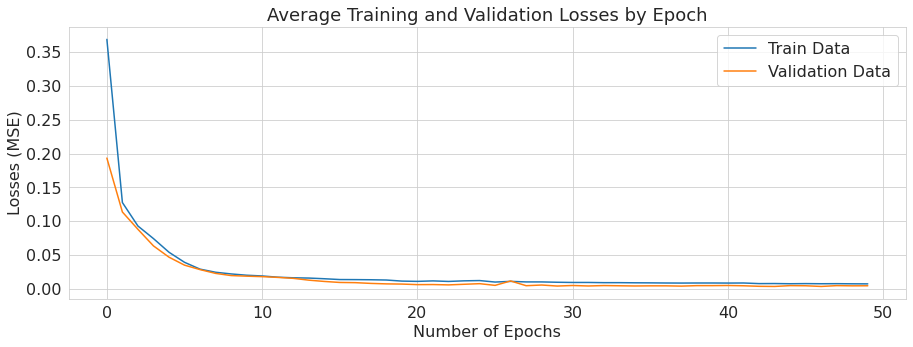

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(range(len(train_losses)), train_losses, label="Train Data");
plt.plot(range(len(valid_losses)), valid_losses, label="Validation Data");
plt.xlabel("Number of Epochs", fontsize=16);
plt.ylabel("Losses (MSE)", fontsize=16);
plt.title("Average Training and Validation Losses by Epoch", fontsize=18);
plt.legend(fontsize=16);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);

In [ ]:
testing_subset[0][0].shape

torch.Size([7, 12])

In [ ]:
def make_predictions(learner, loader, hidden):
  y_pred = []
  y_true = []
  with torch.no_grad():
    for X, y in loader:
      out, hidden = learner(X, hidden)
      hidden = hidden.data
      y_pred.extend(list(out.numpy().flatten()))
      y_true.extend(list(y.numpy().flatten()))

  return y_pred, y_true

In [ ]:
y_pred, y_true = make_predictions(trained_learner, loaders["test"], hidden)

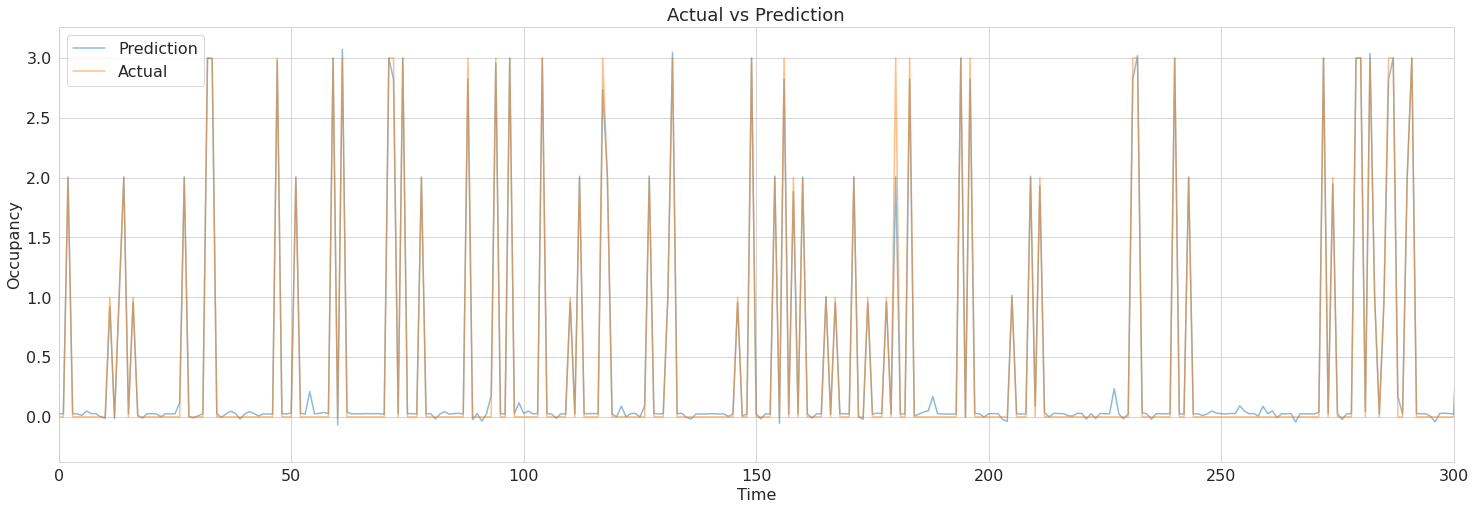

In [ ]:
plt.figure(figsize=(25,8));
plt.plot(range(len(y_pred)), y_pred, alpha=0.5, label="Prediction");
plt.plot(range(len(y_true)), y_true, alpha=0.5, label="Actual");
plt.xlim([0,300]);
plt.xlabel("Time", fontsize=16);
plt.ylabel("Occupancy", fontsize=16);
plt.title("Actual vs Prediction", fontsize=18);
plt.legend(fontsize=16);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);

### Another Way to Produce the Output

Another option to produce the output is to use all the time steps (lags) as input to the output layer. Therefore, we would have a vector with size (batch_size X num_lags, hidden_dim). Then, after passing this vector to the output layer, we could break it back again to its original dimension and then take only the results for the last lag, for example. This is just a way to use all time steps to update the last layer. An example is shown below.

In [ ]:
class RNN(nn.Module):
  def __init__(self, input_size, output_size, hidden_dim, n_layers):
    super(RNN, self).__init__()
    self.hidden_dim = hidden_dim
    self.output_size = output_size
    self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_size)

  def forward(self, x, hidden):
    batch_size = x.size(0)

    #r_out: (batch_size, seq_length (T), hidden_dim (h))
    #hidden: (batch_size, hidden_dim) -> This is the state vector! 
    #To understando the difference between r_out and hidden:
    #https://stackoverflow.com/a/48305882
    r_out, hidden = self.rnn(x, hidden)

    #Stack up LSTM Outputs to Apply Linear Layer
    #The input shape to the linear layer will be
    #(batch_size X seq_length, hidden_dim)
    r_out = r_out.contiguous().view(-1, self.hidden_dim)

    #(batch_size X seq_length, 1)
    output = self.fc(r_out)
    output = output.view(batch_size, -1, self.output_size)

    #Get last output (most recent lag)
    #(batch_size, 1)
    output = output[:, -1] 


    return output, hidden